In [ ]:
from __future__ import print_function
#%matplotlib inline
import pickle
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Do not modify the seed to reproduce the results
manualSeed = 999
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

In [ ]:
# I used Google Colab to train models
# The dataset is stored on my Google Drive
from google.colab import drive
drive.mount('/content/drive')

In [12]:
# You can download the dataset archive here https://www.kaggle.com/greg115/abstract-art
# !unzip ./drive/MyDrive/archive.zip -d ./drive/MyDrive/abstract_art

In [13]:
# Root directory for dataset
dataroot = "./drive/MyDrive/abstract_art"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Size of training images that will be yielded from Dataloader
image_size = 64

# Number of color channels for the images
num_channels = 3

# Size of z 
# random latent vector that Generator uses to generate images
z_size = 100

# Number of filter channels for the first convolution layer
# for the Generator model
gen_features = 64

# Number of filter channels for the first convolution layer
# for the Discriminator model
disc_features = 64

# Number of training epochs
num_epochs = 400

# Learning rate for optimizer
lr = 0.0002

# Beta1 hyperparam for Adam optimizer
beta1 = 0.5

# Number of GPUs available
ngpu = torch.cuda.device_count()

In [ ]:
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.RandomCrop(image_size),
                               transforms.RandomHorizontalFlip(),
                               transforms.RandomVerticalFlip(),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [15]:
# custom weights initialization called on netG and netD
# uses different zero-mean initialization for convolution layers
# unit-mean intialization for batchnorm
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [16]:
# Generator Code
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is latent vector Z, going into a convolution
            nn.ConvTranspose2d(z_size, gen_features * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(gen_features * 8),
            nn.ReLU(True),
            # state size: (gen_features*8) x 4 x 4
            nn.ConvTranspose2d(gen_features * 8, gen_features * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(gen_features * 4),
            nn.ReLU(True),
            # state size: (gen_features*4) x 8 x 8
            nn.ConvTranspose2d( gen_features * 4, gen_features * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(gen_features * 2),
            nn.ReLU(True),
            # state size: (gen_features*2) x 16 x 16
            nn.ConvTranspose2d( gen_features * 2, gen_features, 4, 2, 1, bias=False),
            nn.BatchNorm2d(gen_features),
            nn.ReLU(True),
            # state size: (gen_features) x 32 x 32
            nn.ConvTranspose2d( gen_features, num_channels, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size: (num_channels) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
netG = Generator(ngpu).to(device)

# For those lucky that have multiple GPUs
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

netG.apply(weights_init)

print(netG)

In [18]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (num_channels) x 64 x 64
            nn.Conv2d(num_channels, disc_features, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (disc_features) x 32 x 32
            nn.Conv2d(disc_features, disc_features * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(disc_features * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (disc_features*2) x 16 x 16
            nn.Conv2d(disc_features * 2, disc_features * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(disc_features * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (disc_features*4) x 8 x 8
            nn.Conv2d(disc_features * 4, disc_features * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(disc_features * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (disc_features*8) x 4 x 4
            nn.Conv2d(disc_features * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
netD = Discriminator(ngpu).to(device)

if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

netD.apply(weights_init)

print(netD)

In [20]:
# As described we use BCE Loss function
criterion = nn.BCELoss()

# Fixed latent vector to use for progression image generation
fixed_noise = torch.randn(64, z_size, 1, 1, device=device)

real_label = 1.
fake_label = 0.

optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [21]:
# Image snapshots to be used to display progression
img_list = []

# Losses history
G_losses = []
D_losses = []

In [23]:
# helper function to load model and snapshots from a checkpoint
# progress is saved using save_progress function
def load_progress(epoch, dir_name):
  with open(f'{dir_name}/res_arr_{epoch}.pickle', 'rb') as f:
    img_list, G_losses, D_losses = pickle.load(f)
  netD.load_state_dict(torch.load(f'{dir_name}/{epoch}iter_desc'))
  netG.load_state_dict(torch.load(f'{dir_name}/{epoch}iter_gen'))

# saves snapshots and model weights
def save_progress(epoch, dir_name='./drive/MyDrive/abstract_res_snaps'):
  print('saving progress')
  with open(f'{dir_name}/res_arr_{epoch}.pickle', 'wb') as f:
    pickle.dump([img_list, G_losses, D_losses], f)
  torch.save(netD, f'{dir_name}/{epoch}iter_desc')
  torch.save(netG, f'{dir_name}/{epoch}iter_gen')

In [ ]:
# Training Loop

iters = 0

print("Starting Training Loop...")
for epoch in range(num_epochs):
    # saving progress each 50 epochs
    if epoch % 50 == 0:
      save_progress(epoch)
    
    for i, data in enumerate(dataloader, 0):

        netD.zero_grad()

        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)

        output = netD(real_cpu).view(-1)

        # calculating Discriminator error on a real batch
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        noise = torch.randn(b_size, z_size, 1, 1, device=device)
        fake = netG(noise)
        label.fill_(fake_label)

        output = netD(fake.detach()).view(-1)

        # calculating Discriminator error on a fake batch
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()

        # total error on both batches
        errD = errD_real + errD_fake

        # updating Discriminator weights
        optimizerD.step()

        netG.zero_grad()
        label.fill_(real_label)

        output = netD(fake).view(-1)

        # Calculating Generator error
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()

        optimizerG.step()

        # log each 50 batches
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save losses
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Each 500 iterations or on the last iteration
        # Generate new image snapshots for the fixed latent vector
        # Save snapshots to track progression
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

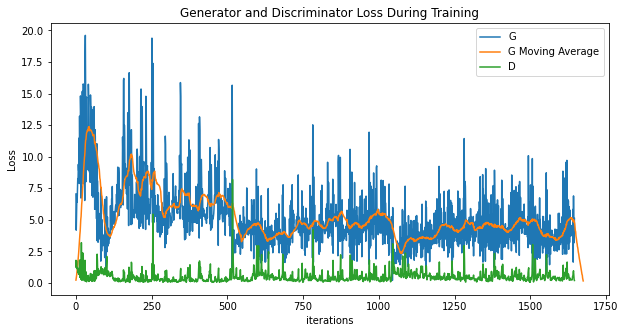

In [27]:
# Plots Generator Loss and its Moving Average
# Along with Discriminator loss
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses, label="G")
plt.plot(np.convolve(G_losses, np.ones(30) / 30), label="G Moving Average")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

# Plots an animated grid for generated image progression
HTML(ani.to_jshtml())

In [ ]:
real_batch = next(iter(dataloader))

# Plots a real batch
plt.figure(figsize=(30,30))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plots fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()